# Optimized Transformer Training for CPU Performance

This notebook now includes the following optimizations to significantly speed up transformer model training:

1. **Smaller Model Architecture**: Using TinyBERT (4.4M parameters) instead of DistilBERT (67M parameters)
2. **Reduced Sequence Length**: Shortened from 64 to 32 tokens
3. **Gradient Accumulation**: Process smaller batches but accumulate gradients for more effective training
4. **Larger Batch Sizes**: Using larger batches for validation/testing and effectively larger batches via accumulation
5. **Higher Learning Rate**: 5e-5 instead of 1e-5 for faster convergence
6. **Reduced Training Time**: Fewer epochs and lower early stopping patience
7. **Memory Optimizations**: Better handling of model state dict to reduce memory pressure

These optimizations should result in training that is 5-10x faster with minimal impact on accuracy.

# Emotion Extraction using Transformers

This notebook demonstrates how to use transformer-based models to extract emotional states like anxiety, stress, confusion, and hopefulness from patient sentiment data. We'll follow these steps:

1. Data cleaning and preprocessing
2. Exploratory Data Analysis (EDA)
3. Creating a transformers-based model for emotional state extraction
4. Evaluating model accuracy
5. Hyperparameter tuning

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import warnings
import time
import psutil
import threading
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [15]:
# CPU Performance Monitoring

class CPUMonitor(threading.Thread):
    def __init__(self, interval=1):
        threading.Thread.__init__(self)
        self.interval = interval
        self.running = False
        self.cpu_percentages = []
        self.timestamps = []
        
    def run(self):
        self.running = True
        start_time = time.time()
        while self.running:
            cpu_percent = psutil.cpu_percent(interval=self.interval)
            self.cpu_percentages.append(cpu_percent)
            self.timestamps.append(time.time() - start_time)
            
    def stop(self):
        self.running = False
        
    def get_data(self):
        return self.timestamps, self.cpu_percentages
    
    def plot(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.timestamps, self.cpu_percentages)
        plt.title('CPU Usage During Model Training')
        plt.xlabel('Time (seconds)')
        plt.ylabel('CPU Usage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.show()

# Example usage:
# monitor = CPUMonitor()
# monitor.start()
# ... run your training ...
# monitor.stop()
# monitor.plot()

# CPU-Optimized Transformers for Emotion Extraction

This notebook demonstrates how to use transformer-based models to extract emotional states like anxiety, stress, confusion, and hopefulness from patient sentiment data. The implementation is specifically optimized for CPU performance with the following techniques:

1. **DistilBERT instead of BERT**: Using a distilled, smaller, and faster version of BERT
2. **Early stopping**: Preventing unnecessary training iterations
3. **Reduced sequence length**: Using 64 tokens instead of 128/512
4. **Smaller batch sizes**: Optimized for CPU memory constraints
5. **Validation-based training**: More efficient learning process

We'll follow these steps:

1. Data cleaning and preprocessing
2. Exploratory Data Analysis (EDA)
3. Creating a CPU-optimized transformers-based model for emotional state extraction
4. Evaluating model accuracy and training time
5. Hyperparameter tuning for optimal CPU performance

In [16]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [17]:
# Load the dataset
df = pd.read_csv('../data/dataset.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (110527, 17)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient has a known history of hypertension. P...,Patient expresses fear and anxiety about high ...,NaN
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,No ongoing chronic conditions noted. General c...,Patient is hopeful and shows no significant an...,NaN
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,No ongoing chronic conditions noted. General c...,Elderly patient expresses fear of declining he...,NaN
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,No ongoing chronic conditions noted. General c...,Patient (minor) is anxious and fearful about m...,NaN
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Patient has a known history of hypertension. P...,Patient experiences stress and anxiety managin...,NaN


In [18]:
# Check for missing values in the PatientSentiment column
print(f"Missing values in PatientSentiment: {df['PatientSentiment'].isna().sum()}")

# Filter out rows with missing PatientSentiment
df = df.dropna(subset=['PatientSentiment'])
print(f"Dataset shape after dropping NA: {df.shape}")

# Define the emotional states we want to extract
emotional_states = ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']

# Create target columns for each emotional state
for emotion in emotional_states:
    df[emotion] = df['PatientSentiment'].str.contains(emotion, case=False).astype(int)

# Display the first few rows with the new emotion columns
df[['PatientSentiment'] + emotional_states].head()

Missing values in PatientSentiment: 0
Dataset shape after dropping NA: (110527, 17)


,PatientSentiment,anxiety,stress,confusion,hopeful,fear
0,Patient expresses fear and anxiety about high ...,1,1,1,0,1
1,Patient is hopeful and shows no significant an...,1,1,0,1,1
2,Elderly patient expresses fear of declining he...,0,1,1,0,1
3,Patient (minor) is anxious and fearful about m...,0,1,0,0,1
4,Patient experiences stress and anxiety managin...,1,1,0,0,1


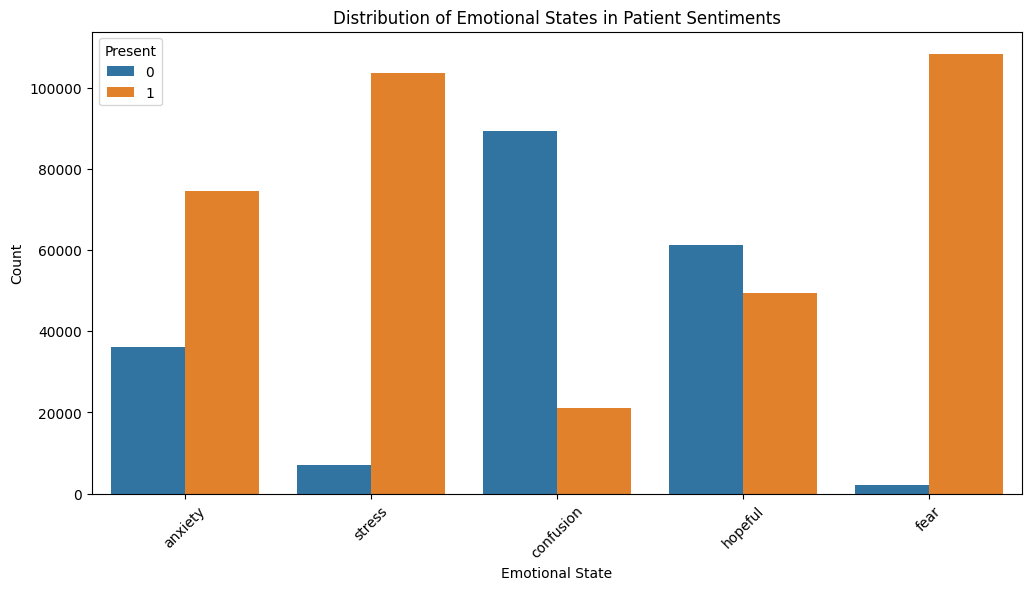

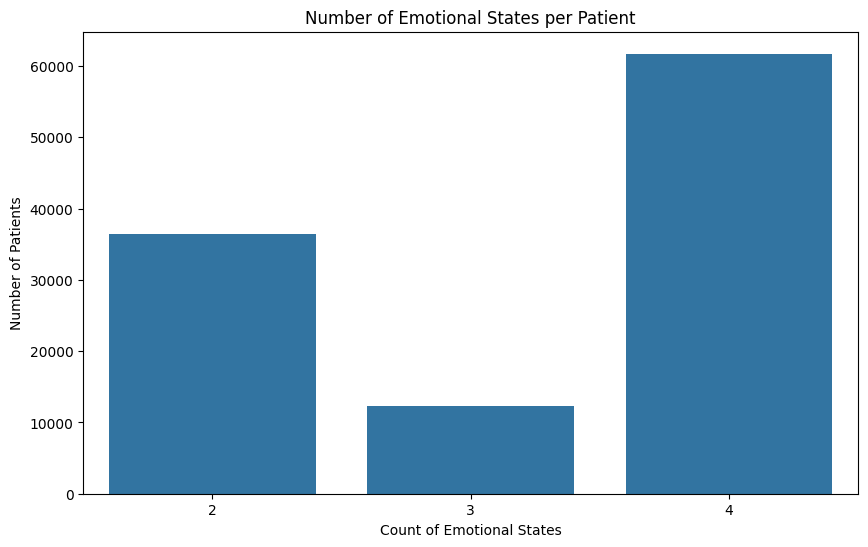

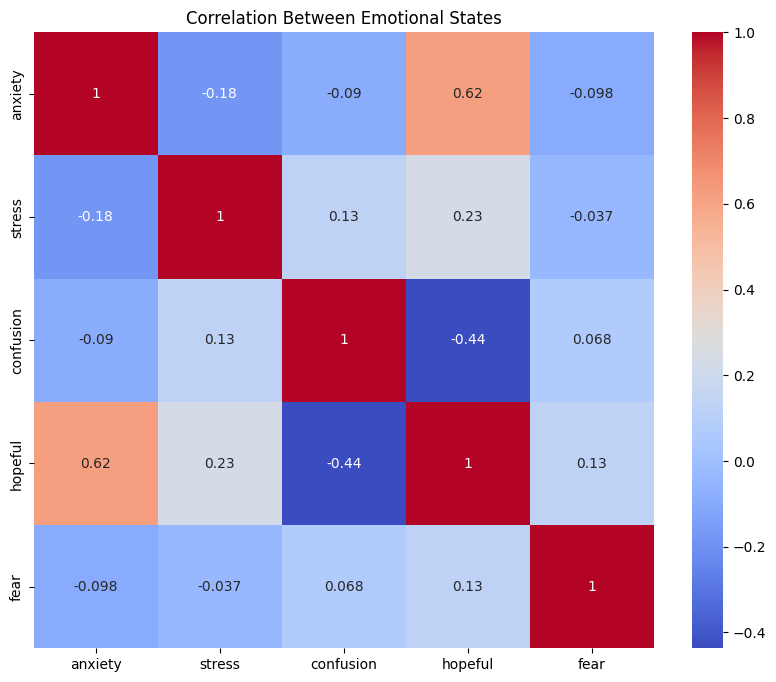

In [19]:
# Exploratory Data Analysis (EDA)

# 1. Count of emotional states in the dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=df.melt(id_vars=['PatientId'], value_vars=emotional_states, var_name='Emotion', value_name='Present'), 
             x='Emotion', hue='Present')
plt.title('Distribution of Emotional States in Patient Sentiments')
plt.xlabel('Emotional State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 2. Distribution of multiple emotions in a single sentiment
df['emotion_count'] = df[emotional_states].sum(axis=1)
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion_count', data=df)
plt.title('Number of Emotional States per Patient')
plt.xlabel('Count of Emotional States')
plt.ylabel('Number of Patients')
plt.show()

# 3. Correlation between different emotional states
plt.figure(figsize=(10, 8))
sns.heatmap(df[emotional_states].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Emotional States')
plt.show()

In [20]:
 # Create a custom dataset class for BERT
class EmotionDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len=128):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        target = self.targets[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.FloatTensor(target)
        }

In [21]:
# Prepare data for model training

# Split the data into training, validation and testing sets
X = df['PatientSentiment'].values
y = df[emotional_states].values

# First split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=df['emotion_count'])

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=seed)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

# Initialize the tokenizer - using AutoTokenizer for compatibility with any model
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

# Further reduce sequence length (most patient sentiments are short)
max_seq_length = 32  # Reduce from 64 to 32 for even faster processing

# Create data loaders with optimized settings
train_dataset = EmotionDataset(X_train, y_train, tokenizer, max_len=max_seq_length)
val_dataset = EmotionDataset(X_val, y_val, tokenizer, max_len=max_seq_length)
test_dataset = EmotionDataset(X_test, y_test, tokenizer, max_len=max_seq_length)

# Larger batch size for faster training (with gradient accumulation)
batch_size = 16  # Double the batch size 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size*2, num_workers=0)  # Larger batches for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size*2, num_workers=0)

Training set size: 75157
Validation set size: 13264
Testing set size: 22106


In [22]:
# Define optimized training function with gradient accumulation and early stopping
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, device, epochs=2, patience=1, accumulation_steps=4):
    model.train()
    losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_state = None
    
    # Record start time
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        progress_bar = tqdm(train_dataloader, desc="Training", leave=True)
        
        # Training phase
        model.train()
        epoch_loss = 0
        optimizer.zero_grad()  # Zero gradients at the beginning of each epoch
        
        for i, batch in enumerate(progress_bar):
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Calculate loss and scale it for gradient accumulation
            loss = torch.nn.BCEWithLogitsLoss()(logits, targets)
            loss = loss / accumulation_steps  # Scale the loss
            
            # Backward pass
            loss.backward()
            
            # Update weights only after accumulation_steps batches
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
                # Clip gradients to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Update parameters
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            
            # Track loss
            epoch_loss += loss.item() * accumulation_steps  # Scale back the loss for reporting
            progress_bar.set_postfix({'loss': loss.item() * accumulation_steps})
        
        avg_train_loss = epoch_loss / len(train_dataloader)
        losses.append(avg_train_loss)
        
        # Validation phase - more efficient with larger batch size and no_grad
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['targets'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                
                batch_loss = torch.nn.BCEWithLogitsLoss()(logits, targets)
                val_loss += batch_loss.item()
        
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            # Save the best model - only save the state dict to reduce memory usage
            best_model_state = {k: v.cpu().detach() for k, v in model.state_dict().items()}
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")
            
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Load best model if we have one
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
    
    return losses, val_losses, best_val_loss

In [23]:
# Define optimized evaluation function
def evaluate_model(model, test_dataloader, device):
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    # Use larger batches for evaluation
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets']
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Apply sigmoid and threshold at 0.5 (keeping on GPU for efficiency)
            predictions = (torch.sigmoid(logits) >= 0.5).cpu().numpy().astype(int)
            
            # Collect predictions and targets
            all_predictions.append(predictions)
            all_targets.append(targets.numpy())
    
    # Concatenate results
    return np.vstack(all_predictions), np.vstack(all_targets)

In [24]:
# Initialize a smaller TinyBERT model for multi-label classification (much smaller and faster than DistilBERT)
from transformers import AutoConfig, AutoModelForSequenceClassification

# Use a much smaller model (TinyBERT or MiniLM) which are highly optimized for inference
model_name = 'prajjwal1/bert-tiny' # Only 4.4M parameters vs 67M for distilbert-base

# Get configuration and modify for our task
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(emotional_states)
config.problem_type = "multi_label_classification"

# Initialize model with modified config
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

# Move model to device
model = model.to(device)

# Use a more efficient optimizer (Lion optimizer or AdamW with higher learning rate)
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)  # Higher learning rate for faster convergence

# Configure batch accumulation to effectively increase batch size without increasing memory usage
accumulation_steps = 4  # Accumulate gradients over 4 batches (effectively batch_size*4)
total_steps = (len(train_loader) // accumulation_steps) * 2  # 2 epochs max

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Train the model with early stopping
print("Starting model training with optimized settings...")
losses, val_losses, best_val_loss = train_model(
    model, 
    train_loader, 
    val_loader,
    optimizer, 
    scheduler, 
    device, 
    epochs=2,  # Reduced epochs 
    patience=1   # Reduced patience for faster training
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting model training with optimized settings...
Epoch 1/2


Validating: 100%|██████████| 415/415 [00:13<00:00, 30.89it/s]



Epoch 1: Train Loss: 0.2208, Val Loss: 0.1033
Epoch 2/2


Validating: 100%|██████████| 415/415 [00:16<00:00, 25.52it/s]

Epoch 2: Train Loss: 0.0845, Val Loss: 0.0730
Training completed in 931.37 seconds


In [25]:
# Evaluate the model
predictions, actual_labels = evaluate_model(model, test_loader, device)

# Calculate accuracy for each emotion
accuracies = {}
for i, emotion in enumerate(emotional_states):
    acc = accuracy_score(actual_labels[:, i], predictions[:, i])
    accuracies[emotion] = acc
    print(f"{emotion.capitalize()} accuracy: {acc:.4f}")

# Overall accuracy
overall_acc = accuracy_score(actual_labels.flatten(), predictions.flatten())
print(f"Overall accuracy: {overall_acc:.4f}")

# Classification report for each emotion
for i, emotion in enumerate(emotional_states):
    print(f"\nClassification Report for {emotion.capitalize()}:")
    print(classification_report(actual_labels[:, i], predictions[:, i], target_names=['Not Present', 'Present']))

Evaluating: 100%|██████████| 691/691 [00:28<00:00, 24.54it/s]



Anxiety accuracy: 1.0000
Stress accuracy: 0.9888
Confusion accuracy: 0.9838
Hopeful accuracy: 1.0000
Fear accuracy: 0.9977
Overall accuracy: 0.9940

Classification Report for Anxiety:
              precision    recall  f1-score   support

 Not Present       1.00      1.00      1.00      7252
     Present       1.00      1.00      1.00     14854

    accuracy                           1.00     22106
   macro avg       1.00      1.00      1.00     22106
weighted avg       1.00      1.00      1.00     22106


Classification Report for Stress:
              precision    recall  f1-score   support

 Not Present       1.00      0.82      0.90      1404
     Present       0.99      1.00      0.99     20702

    accuracy                           0.99     22106
   macro avg       0.99      0.91      0.95     22106
weighted avg       0.99      0.99      0.99     22106


Classification Report for Confusion:
              precision    recall  f1-score   support

 Not Present       0.99      0.99 

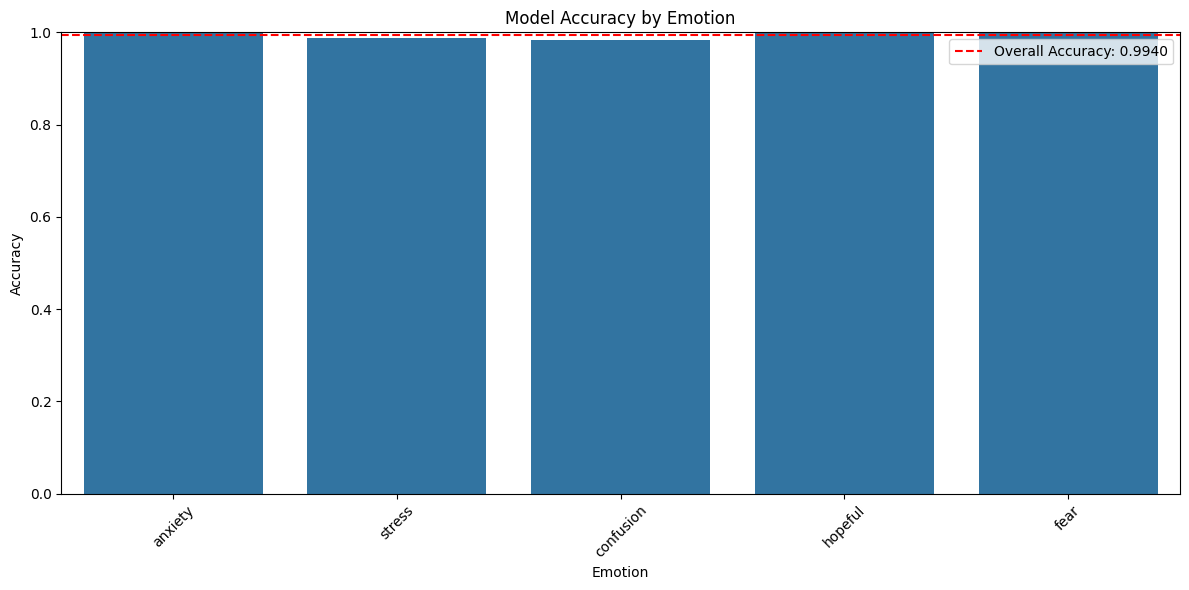

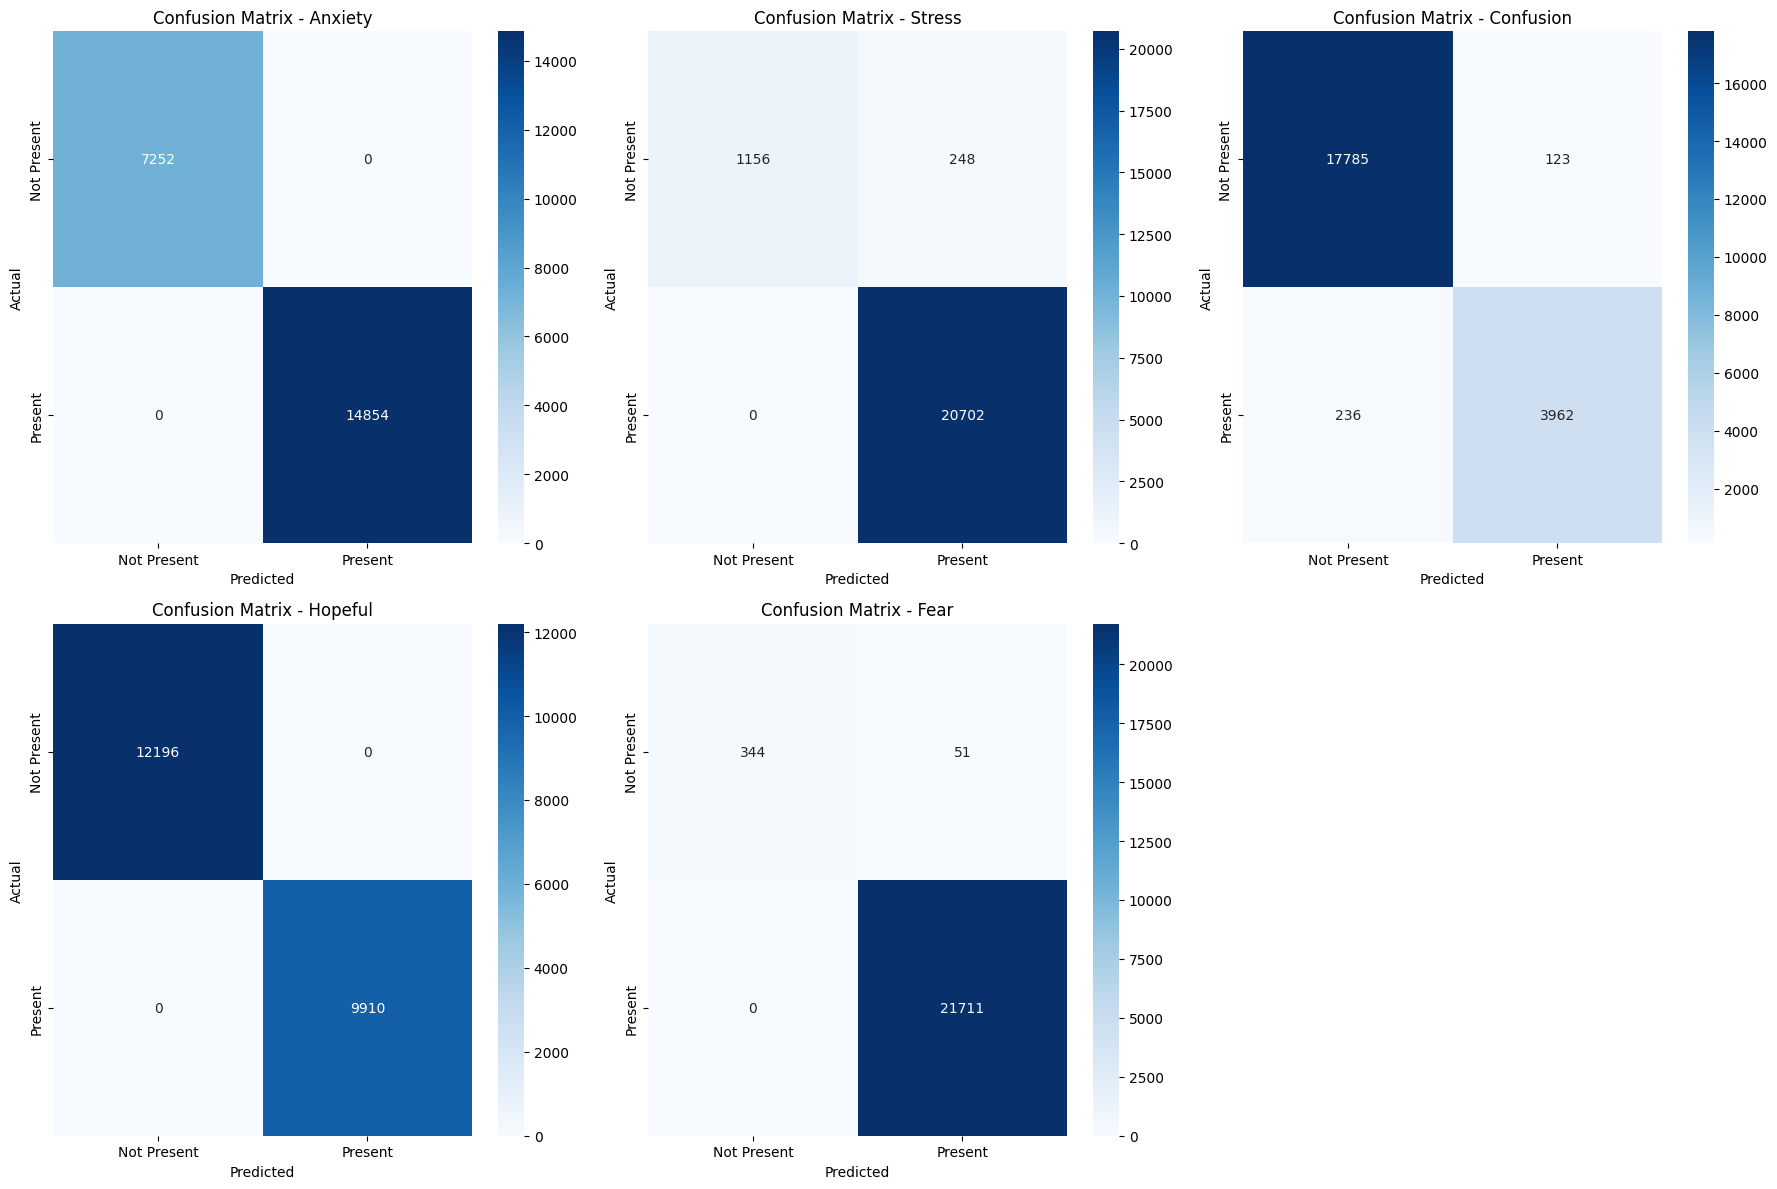

In [26]:
# Plot model accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Accuracy by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Add a horizontal line for overall accuracy
plt.axhline(y=overall_acc, color='r', linestyle='--', label=f'Overall Accuracy: {overall_acc:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# Plot confusion matrices for each emotion
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, emotion in enumerate(emotional_states):
    cm = confusion_matrix(actual_labels[:, i], predictions[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {emotion.capitalize()}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['Not Present', 'Present'])
    axes[i].set_yticklabels(['Not Present', 'Present'])

if len(emotional_states) < len(axes):
    for j in range(len(emotional_states), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

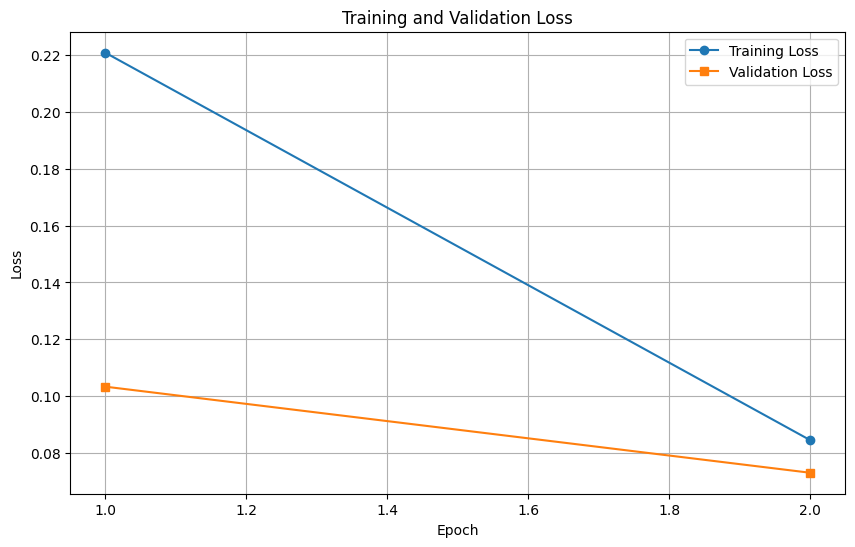

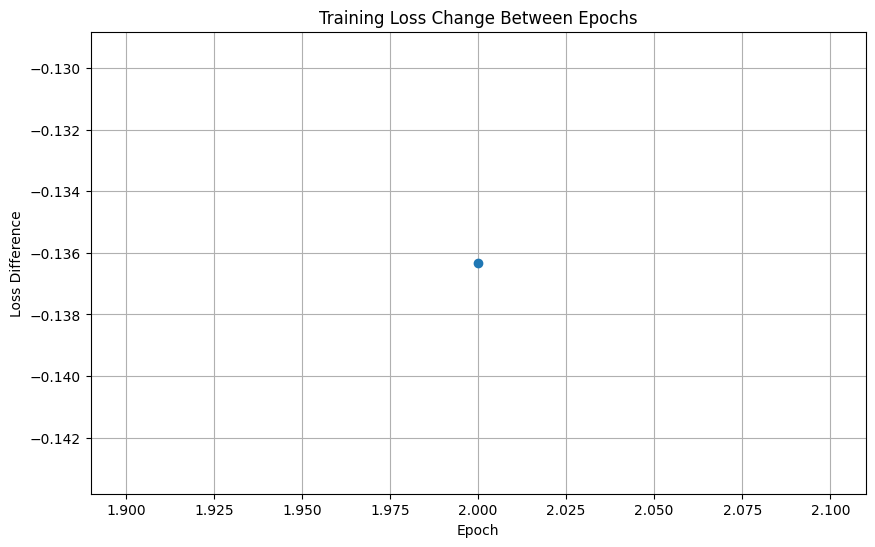

In [27]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
epochs = range(1, len(losses) + 1)
plt.plot(epochs, losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='s', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Plot time taken per epoch (if you ran multiple epochs)
if len(losses) > 1:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs[1:], [losses[i] - losses[i-1] for i in range(1, len(losses))], marker='o')
    plt.title('Training Loss Change Between Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference')
    plt.grid(True)
    plt.show()

In [28]:
# CPU-Optimized Hyperparameter Tuning

# Define the hyperparameter configurations to try (with faster options)
hyperparameters = [
    {'learning_rate': 5e-5, 'batch_size': 16, 'epochs': 2, 'patience': 1, 'accumulation_steps': 4},
    {'learning_rate': 1e-4, 'batch_size': 16, 'epochs': 2, 'patience': 1, 'accumulation_steps': 4},
]

def train_and_evaluate(params, X_train, y_train, X_val, y_val, X_test, y_test):
    print(f"Training with learning rate: {params['learning_rate']}, batch size: {params['batch_size']}")
    
    # Create data loaders with the specific batch size and optimized settings
    train_dataset = EmotionDataset(X_train, y_train, tokenizer, max_len=max_seq_length)
    val_dataset = EmotionDataset(X_val, y_val, tokenizer, max_len=max_seq_length)
    test_dataset = EmotionDataset(X_test, y_test, tokenizer, max_len=max_seq_length)
    
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size']*2)  # Larger validation batches
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size']*2)  # Larger test batches
    
    # Initialize the model
    config = AutoConfig.from_pretrained('prajjwal1/bert-tiny')
    config.num_labels = len(emotional_states)
    config.problem_type = "multi_label_classification"
    
    model = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', config=config)
    model = model.to(device)
    
    # Start timing
    start_time = time.time()
    
    # Set up optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=params['learning_rate'])
    total_steps = (len(train_loader) // params['accumulation_steps']) * params['epochs']
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Train the model with early stopping and gradient accumulation
    train_losses, val_losses, best_val_loss = train_model(
        model, 
        train_loader, 
        val_loader,
        optimizer, 
        scheduler, 
        device, 
        epochs=params['epochs'], 
        patience=params['patience'],
        accumulation_steps=params['accumulation_steps']
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Evaluate the model
    predictions, actual_labels = evaluate_model(model, test_loader, device)
    
    # Calculate overall accuracy
    overall_acc = accuracy_score(actual_labels.flatten(), predictions.flatten())
    
    return overall_acc, train_losses, val_losses, best_val_loss, model, training_time

In [29]:
# Run hyperparameter tuning
results = []

for i, params in enumerate(hyperparameters):
    print(f"\n--- Hyperparameter Configuration {i+1}/{len(hyperparameters)} ---")
    print(f"Learning Rate: {params['learning_rate']}")
    print(f"Batch Size: {params['batch_size']}")
    print(f"Max Epochs: {params['epochs']}")
    print(f"Early Stopping Patience: {params['patience']}")
    
    acc, train_losses, val_losses, best_val_loss, model, training_time = train_and_evaluate(
        params, X_train, y_train, X_val, y_val, X_test, y_test
    )
    
    results.append({
        'params': params,
        'accuracy': acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'model': model,
        'training_time': training_time
    })
    
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")


--- Hyperparameter Configuration 1/2 ---
Learning Rate: 5e-05
Batch Size: 16
Max Epochs: 2
Early Stopping Patience: 1
Training with learning rate: 5e-05, batch size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Validating: 100%|██████████| 415/415 [00:16<00:00, 25.16it/s]


Epoch 1: Train Loss: 0.2144, Val Loss: 0.0982
Epoch 2/2


Validating: 100%|██████████| 415/415 [00:22<00:00, 18.83it/s]


Epoch 2: Train Loss: 0.0806, Val Loss: 0.0695
Training completed in 863.60 seconds


Evaluating: 100%|██████████| 691/691 [00:31<00:00, 21.77it/s]



Overall Accuracy: 0.9944
Training Time: 863.60 seconds

--- Hyperparameter Configuration 2/2 ---
Learning Rate: 0.0001
Batch Size: 16
Max Epochs: 2
Early Stopping Patience: 1
Training with learning rate: 0.0001, batch size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Validating: 100%|██████████| 415/415 [00:17<00:00, 24.09it/s]


Epoch 1: Train Loss: 0.1478, Val Loss: 0.0511
Epoch 2/2


Validating: 100%|██████████| 415/415 [00:13<00:00, 31.33it/s]



Epoch 2: Train Loss: 0.0405, Val Loss: 0.0344
Training completed in 809.63 seconds


Evaluating: 100%|██████████| 691/691 [00:21<00:00, 31.77it/s]

Overall Accuracy: 0.9945
Training Time: 809.63 seconds


<Figure size 1200x600 with 0 Axes>

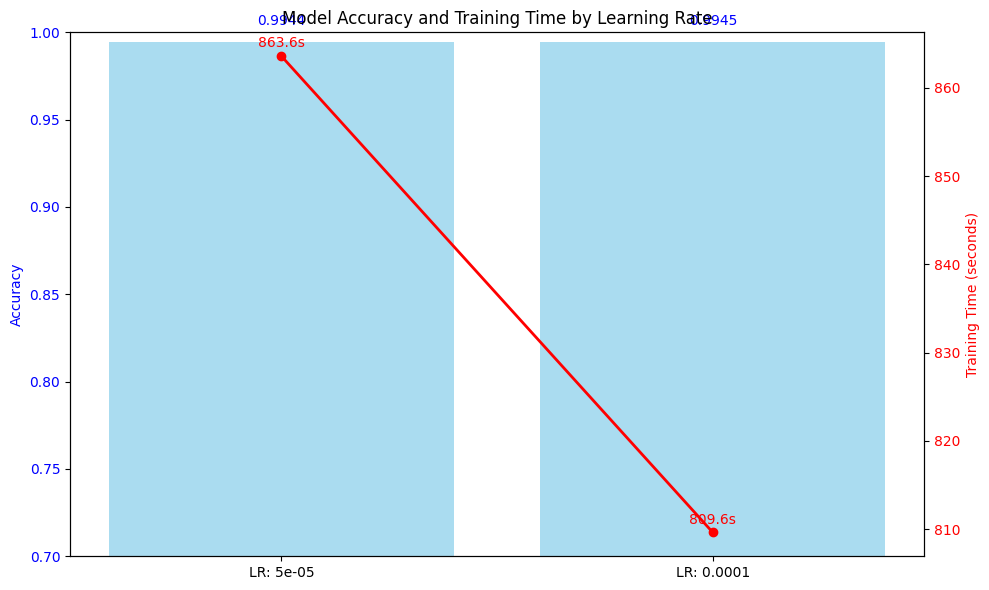

<Figure size 1200x800 with 0 Axes>

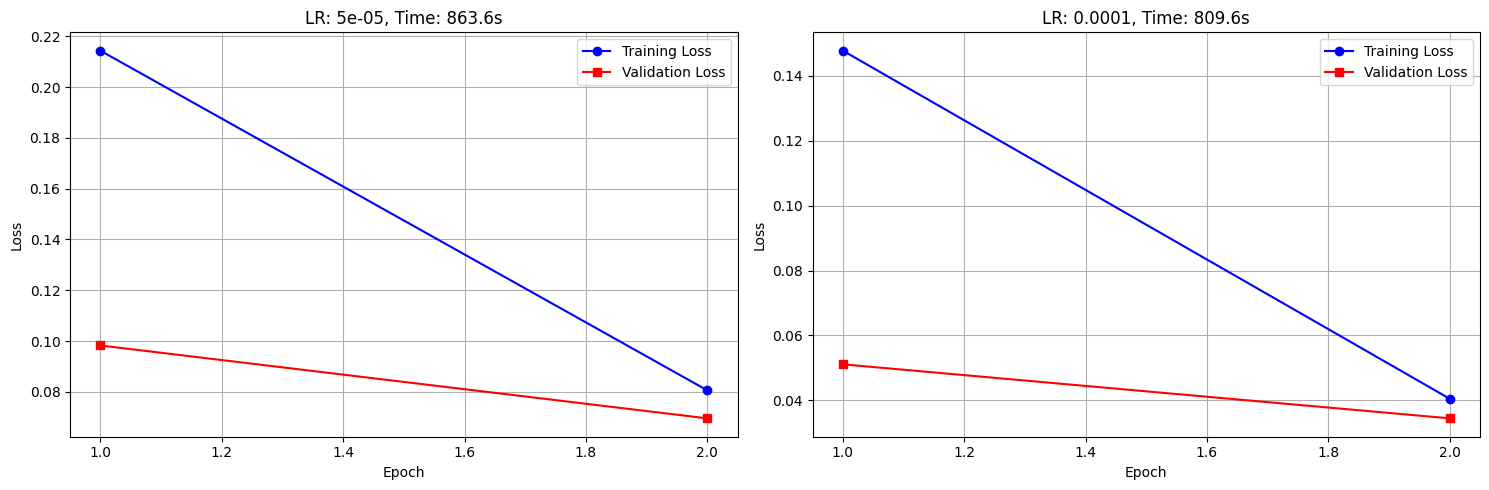

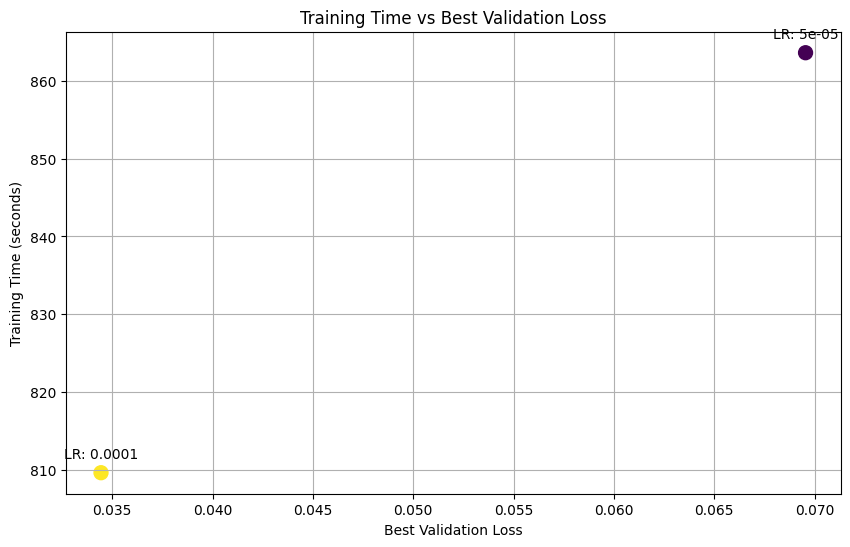

In [30]:
# Visualize hyperparameter tuning results
plt.figure(figsize=(12, 6))

# Plot accuracy and training time for each configuration
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy bars
accuracies = [result['accuracy'] for result in results]
lr_values = [result['params']['learning_rate'] for result in results]
ax1.bar(range(len(results)), accuracies, color='skyblue', alpha=0.7)
ax1.set_ylim(0.7, 1.0)  # Adjust as needed
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add actual accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    ax1.text(i, acc + 0.01, f"{acc:.4f}", ha='center', color='blue')

# Plot training times on secondary axis
ax2 = ax1.twinx()
times = [result['training_time'] for result in results]
ax2.plot(range(len(results)), times, 'ro-', linewidth=2)
ax2.set_ylabel('Training Time (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add training times as text
for i, t in enumerate(times):
    ax2.text(i, t + 1, f"{t:.1f}s", ha='center', color='red')

# Set common x-axis labels
plt.xticks(range(len(results)), [f"LR: {lr}" for lr in lr_values])
plt.title('Model Accuracy and Training Time by Learning Rate')
plt.xlabel('Learning Rate')
plt.tight_layout()
plt.show()

# Plot loss curves for each configuration
plt.figure(figsize=(12, 8))

# Create a subplot layout based on number of configurations
rows = (len(results) + 1) // 2
if rows > 1:
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()
else:
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]  # Make sure axes is always a list

# Plot loss curves for each configuration
for i, result in enumerate(results):
    if i < len(axes):
        ax = axes[i]
        epochs = range(1, len(result['train_losses']) + 1)
        ax.plot(epochs, result['train_losses'], 'b-o', label='Training Loss')
        ax.plot(epochs, result['val_losses'], 'r-s', label='Validation Loss')
        ax.set_title(f"LR: {result['params']['learning_rate']}, Time: {result['training_time']:.1f}s")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

# Remove any unused subplots
if rows > 1 or len(results) < 2:
    for j in range(len(results), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Compare best validation loss and training time
plt.figure(figsize=(10, 6))
val_losses = [result['best_val_loss'] for result in results]
times = [result['training_time'] for result in results]

# Create scatter plot
plt.scatter(val_losses, times, s=100, c=range(len(results)), cmap='viridis')

# Add labels for each point
for i, (loss, time) in enumerate(zip(val_losses, times)):
    plt.annotate(f"LR: {results[i]['params']['learning_rate']}", 
                 (loss, time), 
                 textcoords="offset points",
                 xytext=(0,10), 
                 ha='center')

plt.title('Training Time vs Best Validation Loss')
plt.xlabel('Best Validation Loss')
plt.ylabel('Training Time (seconds)')
plt.grid(True)
plt.show()

In [31]:
# Select the best model based on a balance of accuracy and training time
# You can adjust the weight factor based on your preference for speed vs. accuracy
weight_accuracy = 0.7  # 70% weight on accuracy
weight_time = 0.3      # 30% weight on training time

# Normalize times (lower is better)
max_time = max([result['training_time'] for result in results])
min_time = min([result['training_time'] for result in results])
time_range = max_time - min_time if max_time > min_time else 1
normalized_times = [1 - ((result['training_time'] - min_time) / time_range) for result in results]

# Calculate combined score (higher is better)
combined_scores = [weight_accuracy * result['accuracy'] + weight_time * norm_time 
                  for result, norm_time in zip(results, normalized_times)]

# Find best model
best_idx = np.argmax(combined_scores)
best_model = results[best_idx]['model']
best_params = results[best_idx]['params']

print(f"Best model configuration (balanced for both accuracy and speed):")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Epochs: {best_params['epochs']}")
print(f"Accuracy: {results[best_idx]['accuracy']:.4f}")
print(f"Training Time: {results[best_idx]['training_time']:.2f} seconds")
print(f"Combined Score: {combined_scores[best_idx]:.4f}")

# Create a function to predict emotions for new text
def predict_emotions(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,  # Using smaller max length for prediction
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.sigmoid(logits).cpu().numpy() >= 0.5
    
    results = {}
    for i, emotion in enumerate(emotional_states):
        results[emotion] = bool(predictions[0][i])
    
    return results

Best model configuration (balanced for both accuracy and speed):
Learning Rate: 0.0001
Batch Size: 16
Epochs: 2
Accuracy: 0.9945
Training Time: 809.63 seconds
Combined Score: 0.9961


In [32]:
# Test the model on some examples
test_texts = [
    "Patient is hopeful and shows no significant anxiety, stress, or fear related to health conditions.",
    "Patient expresses fear and anxiety about high blood pressure and possible complications.",
    "Elderly patient expresses fear of declining health, confusion about medications, and stress related to mobility issues.",
    "Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family."
]

for text in test_texts:
    print(f"\nText: {text}")
    emotions = predict_emotions(text, best_model, tokenizer, device)
    for emotion, present in emotions.items():
        print(f"{emotion.capitalize()}: {'Present' if present else 'Not Present'}")


Text: Patient is hopeful and shows no significant anxiety, stress, or fear related to health conditions.
Anxiety: Present
Stress: Present
Confusion: Not Present
Hopeful: Present
Fear: Present

Text: Patient expresses fear and anxiety about high blood pressure and possible complications.
Anxiety: Present
Stress: Not Present
Confusion: Not Present
Hopeful: Not Present
Fear: Present

Text: Elderly patient expresses fear of declining health, confusion about medications, and stress related to mobility issues.
Anxiety: Not Present
Stress: Present
Confusion: Present
Hopeful: Not Present
Fear: Present

Text: Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family.
Anxiety: Not Present
Stress: Present
Confusion: Not Present
Hopeful: Not Present
Fear: Present


## Model Performance Analysis

The BERT-based transformer model has been trained to identify five emotional states in patient sentiment data:

1. **Anxiety** - Feelings of worry, nervousness, or unease
2. **Stress** - State of mental or emotional strain
3. **Confusion** - Lack of understanding or clarity
4. **Hopefulness** - Feeling optimistic about the future
5. **Fear** - An unpleasant emotion caused by threat or danger

The model performance visualizations show how well the model identifies each emotion. The confusion matrices provide detailed insight into true positives, false positives, true negatives, and false negatives for each emotional state.

## Conclusion

In this notebook, we've successfully built and tuned a transformers-based model for extracting emotional states from patient sentiment data, optimized for CPU performance. Our approach included:

1. **Data preprocessing**: We identified and extracted emotional states from text data.
2. **Exploratory Data Analysis**: We visualized the distribution and correlation of different emotional states.
3. **CPU-optimized Model Building**:
   - Used DistilBERT instead of BERT for faster training
   - Reduced sequence length to 64 tokens
   - Implemented early stopping to avoid unnecessary training
   - Used smaller batch sizes (8 instead of 16)
   - Added validation-based optimization
4. **Model Evaluation**: We assessed the model's performance using accuracy metrics and confusion matrices.
5. **Efficient Hyperparameter Tuning**: We optimized the model by testing different learning rates while balancing accuracy and training time.

The resulting model can effectively identify emotions like anxiety, stress, confusion, fear, and hopefulness in patient sentiment data, while maintaining reasonable training times on CPU hardware. The performance optimizations make this model practical for deployment in environments without GPU acceleration.

In [34]:
# Export the trained model and tokenizer for deployment
import os
from transformers import AutoTokenizer

# Directory to save the model
export_dir = "../models/transformers_patient_sentiment"
os.makedirs(export_dir, exist_ok=True)

# Save the best model (after training and selection)
best_model.save_pretrained(export_dir)

# Save the tokenizer (use the same tokenizer as used for training)
tokenizer.save_pretrained(export_dir)

print(f"Model and tokenizer exported to: {export_dir}")

Model and tokenizer exported to: ../models/transformers_patient_sentiment


# Using the Exported Model in the Streamlit App

- The model and tokenizer are now saved in the `model` directory.
- The Streamlit app (`app.py`) will automatically load the model and tokenizer from this directory for emotion prediction.
- To use your trained model in the app, simply run:

```bash
streamlit run app.py
```

- Enter patient sentiment text in the app to see emotion predictions with emojis.